UMAP transformation and clustering

In [20]:
import scipy
from scipy.sparse import csr_matrix
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap
import networkx as nx
from compress_pickle import load, dump
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from statistics import mean, median
from joblib import Parallel, delayed
from itertools import product

from ease import EASE
path = "./files/"

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})
regulome_network_edges['dist'] = 1 - regulome_network_edges['PPV']
regulome_graph = nx.from_pandas_edgelist(regulome_network_edges, source='ProteinAid', target='ProteinBid', edge_attr='dist')
node_names = [name for name in regulome_graph.nodes()]

msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
msigdb_c3_tft_dict = {setid:genes for setid, genes in msigdb_c3_tft_dict.items() if len(genes) >= 5}

In [9]:
# create sparse pandas df
sparse_adjacency = csr_matrix(nx.to_scipy_sparse_array(regulome_graph, nodelist=node_names))
scaled_adjacency = StandardScaler(with_mean=False).fit_transform(sparse_adjacency)
scaled_adjacency = pd.DataFrame.sparse.from_spmatrix(scaled_adjacency, index=node_names, columns=node_names)

In [12]:
# grid search
def fit_umap(df, n_neighbors, n_dimensions=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    embedding = reducer.fit_transform(df)
    embedding_df = pd.DataFrame(embedding, index=node_names, columns=['UMAP1', 'UMAP2'])
    return embedding_df

def cluster_umap_DBSCAN(df, eps, min_samples):
    clusters = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(df)
    n_clusters = max(clusters) + 1
    df['clusterid'] = clusters
    clusters_dict = dict()

    for cluster_id in df['clusterid'].unique():
        cluster = tuple(df[df['clusterid'] == cluster_id].index)
        if len(cluster) > 5 and len(cluster) < 200:
            clusters_dict[int(cluster_id)] = cluster
    return df, clusters_dict, n_clusters

def enrichment_ease(clusters, gene_set):
    enrichment_dict = dict()
    for (clusterid, cluster) in clusters.items():
        enrichment = EASE(query_set=cluster, genesets=gene_set, PT=regulome_graph.number_of_nodes())
        enrichment_dict[clusterid] = (enrichment, len(cluster), cluster) # maybe save this as a namedtuple with enrihcment and subgraph
    return enrichment_dict

def calculate_CCS(enrichment_dict, threshold=0.05):
    enrichments = list()
    for cluster in enrichment_dict.values():
        cluster = cluster[0]
        enriched = cluster[cluster['FDR'] < threshold]
        if enriched.empty:
            continue
        enrichments.append(enriched[:][['pathway_id', 'FDR']])
    n_enriched_clusters = len(enrichments)
    enriched_df = pd.concat(enrichments)
    avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
    avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    CCS = avg_set_per_cluster / avg_cluster_per_set

    return CCS, n_enriched_clusters, avg_set_per_cluster, avg_cluster_per_set

def grid_search_n_iteration(eps, nn):
    print(f"Working on {eps}, {nn}")
    embedding_df_clusters, clusters_dict, n_clusters_unfiltered = cluster_umap_DBSCAN(deepcopy(embedding_df), eps=eps, min_samples=nn)
    del embedding_df_clusters
    cluster_sizes = [len(cluster) for cluster in clusters_dict.values()]
    enrichment = enrichment_ease(clusters_dict, msigdb_c3_tft_dict)
    results = calculate_CCS(enrichment)
    results_dict = {'n_neighbors': n,
                    'eps': eps,
                    'nn': nn,
                    'n_nodes': sum(cluster_sizes),
                    'n_clusters': n_clusters_unfiltered,
                    'n_clusters_filt': len(cluster_sizes)s,
                    'avg_size': mean(cluster_sizes),
                    'median_size': median(cluster_sizes),
                    'n_enriched': results[1],
                    '%_enriched': results[1]/len(cluster_sizes),
                    'avg_s/c': results[2],
                    'avg_c/s':results[3],
                    'CCS': results[0]}
    return results_dict


eps_range = [0.1, 0.3, 0.5, 0.7, 0.9]
nn_range = [1,2,3,4,5,6]

for n in [5, 15, 30, 45, 60]:
    embedding_df = fit_umap(scaled_adjacency, n_neighbors=n)
    print(f"Starting clustering {n}")
    parallel = Parallel(n_jobs=10, verbose=0)
    results = parallel(delayed(grid_search_n_iteration)(eps, nn) for (eps, nn) in product(eps_range, nn_range))
    results_df = pd.DataFrame.from_records(results)

with open(path+'umap_clustering_2D_results.gz', 'wb') as file:
    dump(results_df, compression='infer')

/home/vinic/miniconda3/envs/umap/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Working on 5, 0.1, 1
Working on 5, 0.1, 2
Working on 5, 0.1, 3
Working on 5, 0.1, 4


KeyboardInterrupt: 

In [278]:
clusters = DBSCAN(eps=0.05, min_samples=6).fit_predict(embedding_df)

embedding_df['clusterid'] = clusters
clusters_dict = dict()

for cluster_id in embedding_df['clusterid'].unique():
    cluster = tuple(embedding_df[embedding_df['clusterid'] == cluster_id].index)
    if len(cluster) > 5 and len(cluster) < 200:
        clusters_dict[int(cluster_id)] = cluster

print(max(clusters))
print(len(clusters_dict))

403
402


In [271]:
def enrichment_ease(clusters, gene_set):
    enrichment_dict = dict()
    for (clusterid, cluster) in clusters.items():
        enrichment = EASE(query_set=cluster, genesets=gene_set, PT=regulome_graph.number_of_nodes())
        enrichment_dict[clusterid] = (enrichment, len(cluster), cluster) # maybe save this as a namedtuple with enrihcment and subgraph
    return enrichment_dict


def calculate_CCS(enrichment_dict, threshold=0.05):
    enrichments = list()
    for cluster in enrichment_dict.values():
        cluster = cluster[0]
        enriched = cluster[cluster['FDR'] < threshold]
        if enriched.empty:
            continue
        enrichments.append(enriched[:][['pathway_id', 'FDR']])
    n_enriched_clusters = len(enrichments)
    enriched_df = pd.concat(enrichments)
    avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
    avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    CCS = avg_set_per_cluster / avg_cluster_per_set

    return CCS, n_enriched_clusters, avg_set_per_cluster, avg_cluster_per_set, n_enriched_clusters/len(enrichment_dict)

enrichment_dict = enrichment_ease(clusters_dict, msigdb_c3_tft_dict)
results = calculate_CCS(enrichment_dict=enrichment_dict)

results

(np.float64(4.857142857142857),
 7,
 4.857142857142857,
 np.float64(1.0),
 0.034653465346534656)

Text(0.5, 1.0, 'UMAP projection of regulome')

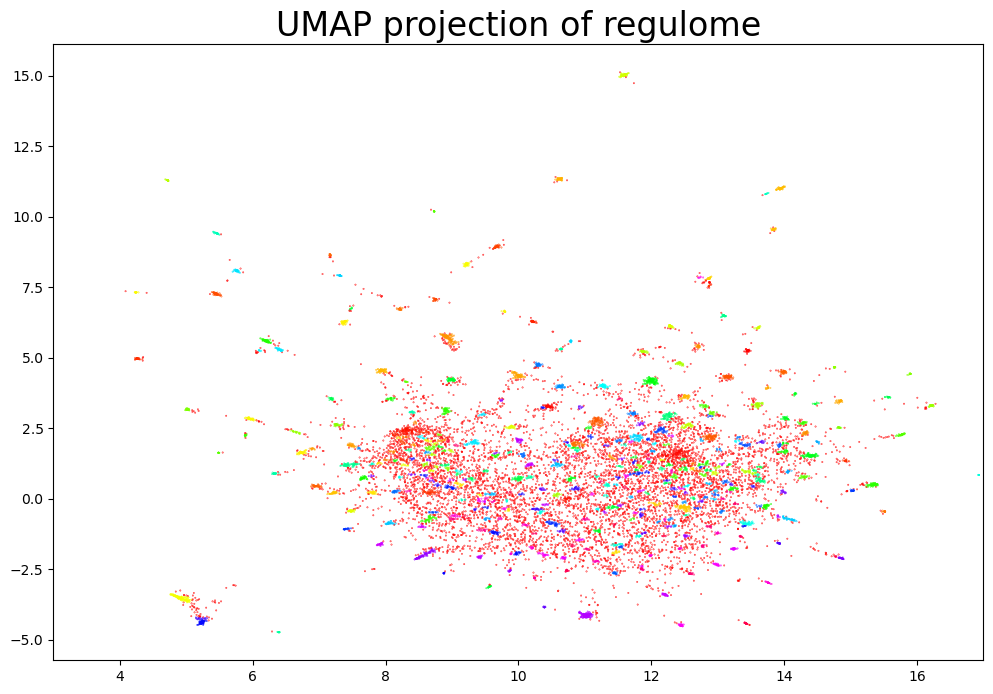

In [281]:

fig, ax = plt.subplots(1,1, figsize=[12,8])
ax.scatter(
    embedding_df['UMAP1'],
    embedding_df['UMAP2'],
    s=0.1,
    c=clusters,
    cmap='hsv'
)
ax.set_xlim([3, 17])
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of regulome', fontsize=24)